<a href="https://colab.research.google.com/github/ziijiecheng/VLM_robustness/blob/main/imaging_artefacts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Install Dependencies

In [1]:
# Install necessary libraries
!pip install torchio matplotlib requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Import Libraries

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchio as tio
from torchio import Subject, ScalarImage
from PIL import Image
import requests
from io import BytesIO
from scipy.ndimage import rotate
from torchvision import transforms
from torchio import Image, Subject, RandomNoise, RandomMotion, RandomBiasField, Compose

Define Augmentation Functions

In [3]:
def augment_image(image_path, augmentations):
    # Load the image as a grayscale PIL Image
    original_image = Image.open(image_path).convert('L')

    # Determine if Crop or Rotate is in the augmentations
    uses_crop_or_rotate = any(isinstance(aug, (RandomCrop, FixedRotation)) for aug in augmentations)

    # Check if RandomMotion is in the augmentations
    motion_aug = next((aug for aug in augmentations if isinstance(aug, RandomMotion)), None)

    if uses_crop_or_rotate:
        # For Crop or Rotate, do not use transforms.ToTensor()
        original_array = np.array(original_image, dtype=np.float32)  # Keep original intensities
        original_tensor = torch.from_numpy(original_array)  # Shape: (H, W)
    else:
        # For other augmentations, use transforms.ToTensor()
        original_tensor = transforms.ToTensor()(original_image)  # Shape: (1, H, W), scaled to [0, 1]
        original_tensor = original_tensor[0]  # Remove channel dimension to get shape: (H, W)

    if motion_aug:
        # For motion artifacts
        # Adjust tensor shape for RandomMotion
        adjusted_tensor = original_tensor.unsqueeze(0).unsqueeze(-1)  # Shape: (1, H, W, 1)
        subject = Subject(image=tio.ScalarImage(tensor=adjusted_tensor))

        # Apply RandomMotion
        augmented_subject = motion_aug(subject)
        random_motion = augmented_subject.history[0]

        # Apply the random motion to a differently shaped tensor
        adjusted_tensor_ = original_tensor.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
        subject_ = Subject(image=tio.ScalarImage(tensor=adjusted_tensor_))
        augmented_subject = random_motion(subject_)

        # Apply other augmentations if any
        other_augs = [aug for aug in augmentations if not isinstance(aug, RandomMotion)]
        if other_augs:
            for aug in other_augs:
                augmented_subject = aug(augmented_subject)
    else:
        # For non-motion augmentations
        adjusted_tensor = original_tensor.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
        subject = Subject(image=tio.ScalarImage(tensor=adjusted_tensor))

        # Apply all augmentations
        for aug in augmentations:
            subject = aug(subject)
        augmented_subject = subject

    # Convert back to numpy array for saving
    augmented_image_numpy = augmented_subject.image.data.numpy()
    image_data = augmented_image_numpy[0, 0, :, :]  # Get the image data

    return image_data  # Return the augmented image data as numpy array

Spatial artefacts

In [4]:
class RandomCrop(tio.Transform):
    def __init__(self, scale_factor):
        super().__init__()
        self.scale_factor = scale_factor

    def apply_transform(self, subject):
        image = subject.image
        data = image.data.squeeze().numpy()  # Remove single dimensions and convert to numpy

        h, w = data.shape
        crop_h = int(h * self.scale_factor)
        crop_w = int(w * self.scale_factor)

        # Ensure crop size doesn't exceed image dimensions
        crop_h = min(crop_h, h)
        crop_w = min(crop_w, w)

        # Calculate random start positions within the image bounds
        start_h = np.random.randint(0, h - crop_h + 1)
        start_w = np.random.randint(0, w - crop_w + 1)

        # Perform the crop
        cropped_data = data[start_h:start_h+crop_h, start_w:start_w+crop_w]
        #cropped_data = (cropped_data - np.min(cropped_data)) / (np.max(cropped_data) - np.min(cropped_data))

        # Convert back to 4D tensor for TorchIO
        cropped_tensor = torch.from_numpy(cropped_data).float().unsqueeze(0).unsqueeze(0)

        # Create a new image with the cropped data
        cropped_subject = tio.Subject(image=tio.ScalarImage(tensor=cropped_tensor, affine=image.affine))

        return cropped_subject

class FixedRotation(tio.Transform):
    def __init__(self, angle):
        super().__init__()
        self.angle = angle

    def apply_transform(self, subject):
        image = subject.image
        data = image.data.numpy()

        # Squeeze the data to remove single-dimensional entries
        data = np.squeeze(data)

        # Ensure the image is 2D
        if len(data.shape) > 2:
            raise ValueError(f"Unexpected data shape: {data.shape}. Expected 2D image.")

        # Rotate the image
        rotated_data = rotate(data, self.angle, reshape=True, mode='constant', cval=0)

        # Normalize the rotated image to 0-1 range
        #rotated_data = (rotated_data - np.min(rotated_data)) / (np.max(rotated_data) - np.min(rotated_data))

        # Reshape to match TorchIO's expected format (1, 1, H, W)
        rotated_data = rotated_data.reshape(1, 1, *rotated_data.shape)

        # Convert back to torch tensor
        rotated_tensor = torch.from_numpy(rotated_data).float()

        # Create new Subject object with rotated image
        rotated_subject = tio.Subject(image=tio.ScalarImage(tensor=rotated_tensor, affine=image.affine))

        return rotated_subject

image augmentations

In [11]:
def process_image(image_path):
    augmentation_strengths = {
    'weak': {
        'Noise': tio.RandomNoise(mean=0, std=0.10),
        'Motion': tio.RandomMotion(degrees=30, translation=30, num_transforms=8),
        'BiasField': tio.RandomBiasField(coefficients=0.7),
        'Crop': RandomCrop(0.8),  # 80% of original size
        'Rotate': FixedRotation(angle=30)
    },
    'strong': {
        'Noise': tio.RandomNoise(mean=0, std=0.35),
        'Motion': tio.RandomMotion(degrees=160, translation=120, num_transforms=32),
        'BiasField': tio.RandomBiasField(coefficients=1.8),
        'Crop': RandomCrop(0.4),  # 20% of original size
        'Rotate': FixedRotation(angle=90)
    },
}

    original_image = np.array(Image.open(image_path).convert('L'))
    # Augment the image for weak and strong transformations
    augmented_images = {
        'original': original_image,
        'weak': {aug_type: augment_image(image_path, [transform]) for aug_type, transform in augmentation_strengths['weak'].items()},
        'strong': {aug_type: augment_image(image_path, [transform]) for aug_type, transform in augmentation_strengths['strong'].items()}
    }

    return augmented_images

visualise augmented images

In [13]:
def visualise_augmentations(augmented_images):
    """
    Visualize the original and augmented images in an organized layout.

    Args:
        augmented_images (dict): Dictionary containing the original image and augmented versions.
    """
    original_image = augmented_images['original']
    aug_types = list(augmented_images['weak'].keys())
    num_augmentations = len(aug_types)

    # Create subplots: rows = num_augmentations, columns = 3 (Original, Weak, Strong)
    fig, axes = plt.subplots(num_augmentations, 3, figsize=(10, 2 * num_augmentations))

    # Visualize each augmentation type
    for row, aug_type in enumerate(aug_types):
        weak_aug = augmented_images['weak'][aug_type]
        strong_aug = augmented_images['strong'][aug_type]

        # First column: Original image for reference
        axes[row, 0].imshow(original_image, cmap='gray')
        axes[row, 0].axis('off')

        # Second column: Weak augmentation
        axes[row, 1].imshow(weak_aug, cmap='gray' if weak_aug.ndim == 2 else None)
        axes[row, 1].axis('off')

        # Third column: Strong augmentation
        axes[row, 2].imshow(strong_aug, cmap='gray' if strong_aug.ndim == 2 else None)
        axes[row, 2].axis('off')

        # Label rows with augmentation type at the top-left corner
        axes[row, 0].set_title(aug_type, fontsize=12, loc='left')

    # Set column labels
    axes[0, 0].set_title("Original", fontsize=12)
    axes[0, 1].set_title("Weak Augmentation", fontsize=12)
    axes[0, 2].set_title("Strong Augmentation", fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()

Test it with a single image

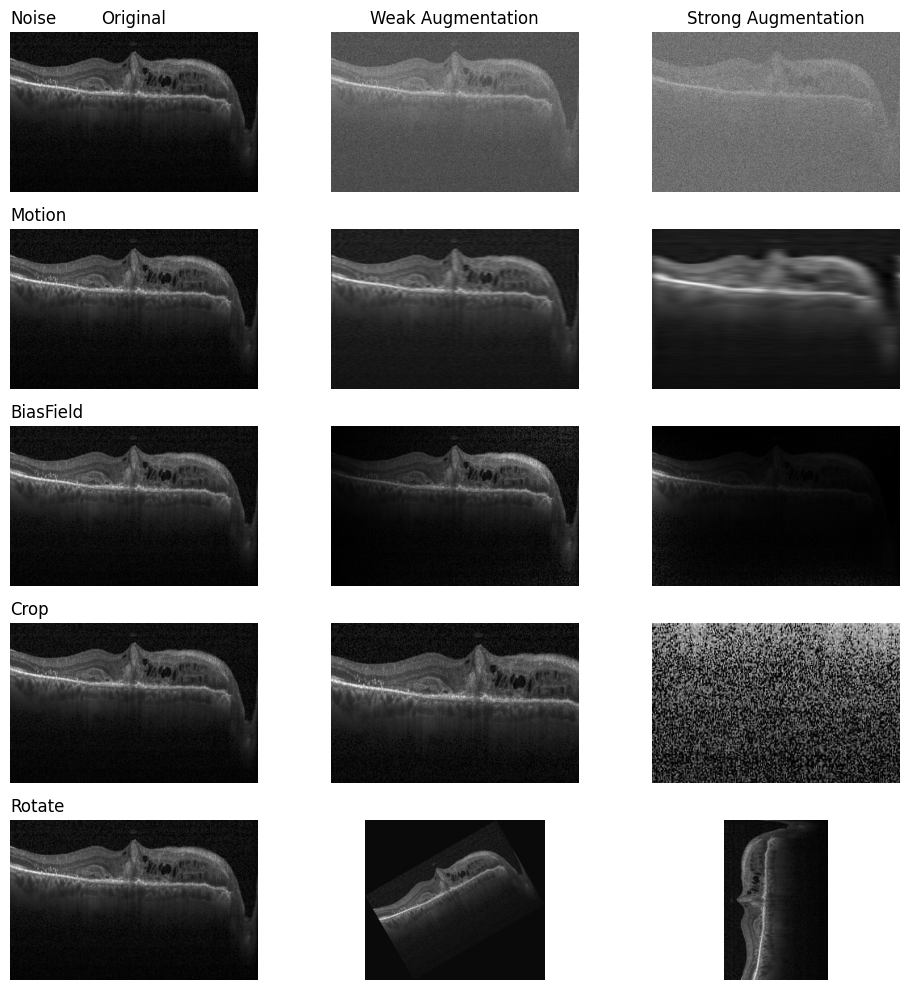

In [14]:
from PIL import Image
# Function to load image from a URL and save it locally
# Function to load image from a URL and save it locally
def load_image_from_url(image_url, save_path='temp_image.jpg'):
    # Send GET request to fetch the image content
    response = requests.get(image_url)

    # Open the image from the response content
    image = Image.open(BytesIO(response.content)).convert('L')

    # Save the image locally so we can pass the path to apply_augmentations
    image.save(save_path)
    return save_path


# Replace this URL with the public image URL you want to use
image_url = 'https://drive.google.com/uc?export=view&id=1pmrnvXwMxgC8fpZ-sz9DJfkSHRYUkSCO'

# Load and save image from URL
image_path = load_image_from_url(image_url)

# Now, use the image_path in your apply_augmentations function
aug_results = process_image(image_path)

# Visualize the augmentations
visualise_augmentations(aug_results)